In [130]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["GCR_CONFIG_SOURCE"] = "files"
from astropy.cosmology import FlatLambdaCDM
import GCR
import GCRCatalogs as GCRCat
import numpy as np
import sys

ROOT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(ROOT_DIR)
import pandas as pd
from matplotlib.lines import Line2D
import itertools
from itertools import permutations
from itertools import product
import utils.utils as ut
import healpy as hp
import astropy
import astropy.units as u
import astropy.cosmology.units as cu
from importlib import reload

dataColumns = np.array(
    [
        "redshift_true",
        "ra_true",
        "dec_true",
        "Mag_true_u_lsst_z0_no_host_extinction",  # Rest frame mags
        "Mag_true_g_lsst_z0_no_host_extinction",
        "Mag_true_r_lsst_z0_no_host_extinction",
        "Mag_true_i_lsst_z0_no_host_extinction",
        "Mag_true_z_lsst_z0_no_host_extinction",
        "Mag_true_Y_lsst_z0_no_host_extinction",
        "mag_true_u_lsst_no_host_extinction",  # Observed mags
        "mag_true_g_lsst_no_host_extinction",
        "mag_true_r_lsst_no_host_extinction",
        "mag_true_i_lsst_no_host_extinction",
        "mag_true_z_lsst_no_host_extinction",
        "mag_true_Y_lsst_no_host_extinction",
        "galaxyID",
        "is_central",
    ]
)

NSIDE = 128

cat_name = "skysim5000_v1.2_small"
skysimCat = GCRCat.load_catalog(cat_name)

# Proof of concept of the reduction pipeline

## Five cases
- Fiducial
- Fiducial + $H_0=50 \texttt{ km s}^{-1} \texttt{ Mpc}^-1$
- Fiducial + LSST Y7
- Fiducial + modeled redshift
- Fiducial + 0.3 mag uniformity

## Plots to make
- Galaxy luminosity function per band, per z-bin
- $P(z)$ distribution
- Redshift precision relative to expectation
- Magnitude non-uniformity plot across healpixel compared to expectation

### Plots

/global/u1/s/seanmacb/DESC/DESC-GW/gwStreetlights/utils/utils.py:311: SyntaxWarning: invalid escape sequence '\p'
  a.set_ylabel("$N_{gals}$")


<module 'utils.utils' from '/global/u1/s/seanmacb/DESC/DESC-GW/gwStreetlights/utils/utils.py'>

## Fiducial
- $H_0=71$
- LSST Y1
- Photo-z, unmodeled
- 0.1 mag

In [2]:
year = 1  # LSST Year 1
modeled = False  # Unmodeled photo-z
uniformity = 0.1  # Mag
airmass = 1.2  # DES average
mags_deeper = 1  # Going one mag deeper than the original projection
z_max = 1.4  # This is where photo-z's break down without IR data

In [3]:
%%time
# Compute limiting mags for year,
limiting_mags = ut.GCR_mag_filter_from_year(
    year, ut.LSST_bands, ut.eTime_dict, ut.visits_dict, airmass=airmass
)

# +1 mag
for b, m in zip(limiting_mags.keys(), limiting_mags.values()):
    limiting_mags[b] = m + mags_deeper  # Add one mag deeper for nonuniformity

# Query using GCR catalogs
filters, band_limit_dict = ut.GCR_filter_overlord(
    year,
    ut.LSST_bands,
    ut.eTime_dict,
    ut.visits_dict,
    airmass=airmass,
    z_max=z_max,
    z_min=0,
    mag_scatter=uniformity,
    nside=NSIDE,
)
data = pd.DataFrame(skysimCat.get_quantities(list(dataColumns), filters=tuple(filters)))
data[f"hp_ind_nside{NSIDE}"] = ut.RaDecToIndex(
    data["ra_true"], data["dec_true"], NSIDE
).astype(
    np.int32
)  # Add healpix column

# Apply redshift adjustment
# None needed for this case

# Get uniformity map
hp_uniq_ids = np.unique(data[f"hp_ind_nside{NSIDE}"])
hp_band_dict = ut.getHp_band_dict(
    hp_uniq_ids, ut.LSST_bands, uniformity, NSIDE, limiting_mags
)

# Apply uniformity map
data = ut.dropFaintGalaxies(data, hp_uniq_ids, ut.LSST_bands, hp_band_dict)

# Compute measured redshift
data["redshift_measured"] = ut.trueZ_to_photoZ(data["redshift_true"], year)

CPU times: user 39.3 s, sys: 38.4 s, total: 1min 17s
Wall time: 1min 23s


In [162]:
reload(ut)  # For debugging the utilities module

/global/u1/s/seanmacb/DESC/DESC-GW/gwStreetlights/utils/utils.py:373: SyntaxWarning: invalid escape sequence '\p'
  a.set_ylabel("$\phi [h^3 Mpc^{-3]}]$")


<module 'utils.utils' from '/global/u1/s/seanmacb/DESC/DESC-GW/gwStreetlights/utils/utils.py'>

/global/u1/s/seanmacb/DESC/DESC-GW/gwStreetlights/utils/utils.py:274: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = inputData[inputData["redshift_measured"] > z_lower][
/global/u1/s/seanmacb/DESC/DESC-GW/gwStreetlights/utils/utils.py:274: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = inputData[inputData["redshift_measured"] > z_lower][
/global/u1/s/seanmacb/DESC/DESC-GW/gwStreetlights/utils/utils.py:274: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = inputData[inputData["redshift_measured"] > z_lower][
/global/u1/s/seanmacb/DESC/DESC-GW/gwStreetlights/utils/utils.py:274: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = inputData[inputData["redshift_measured"] > z_lower][
/global/u1/s/seanmacb/DESC/DESC-GW/gwStreetlights/utils/utils.py:274: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = inputData[inp

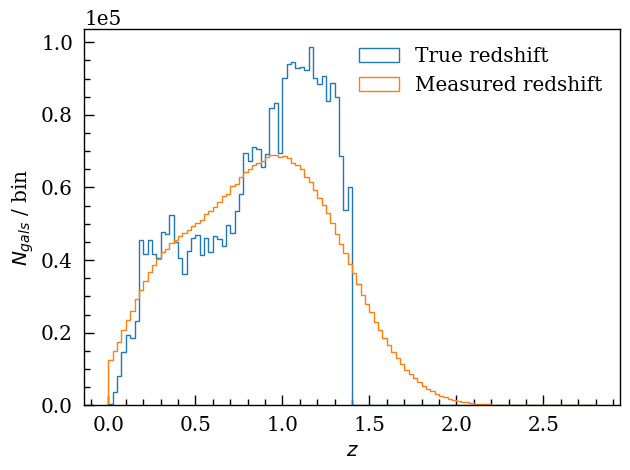

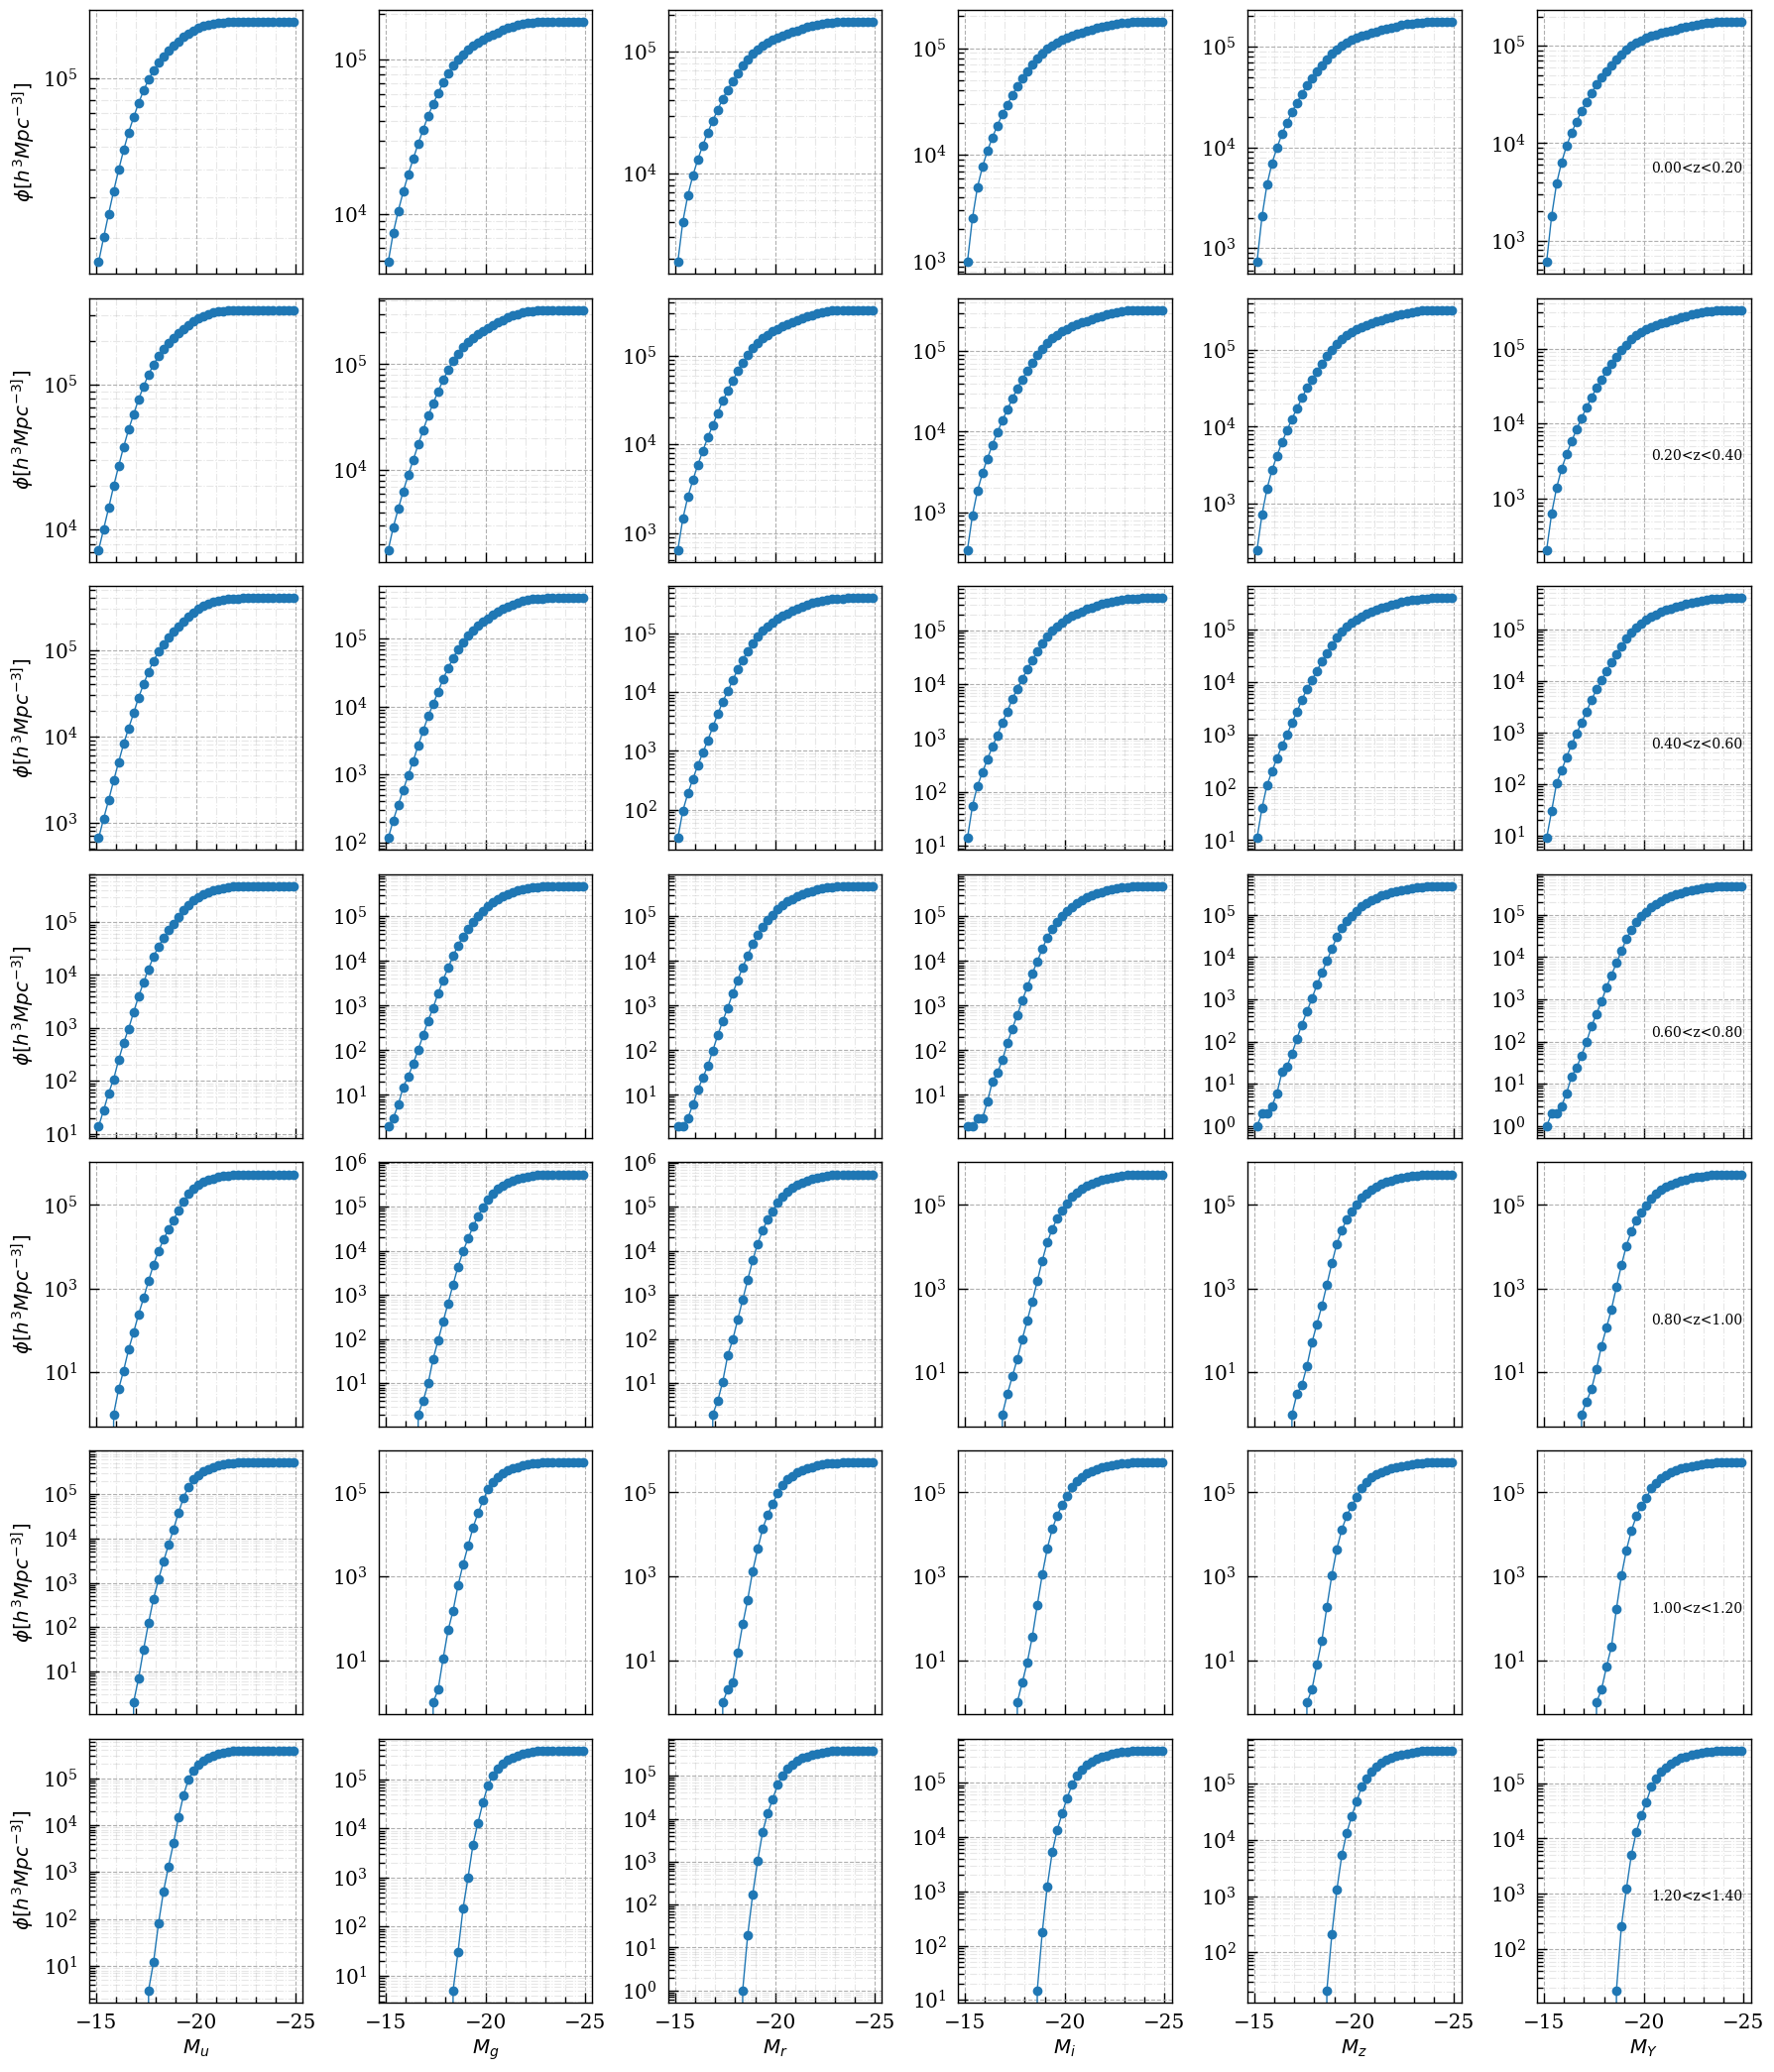

Dataframe passes magnitude limit criteria


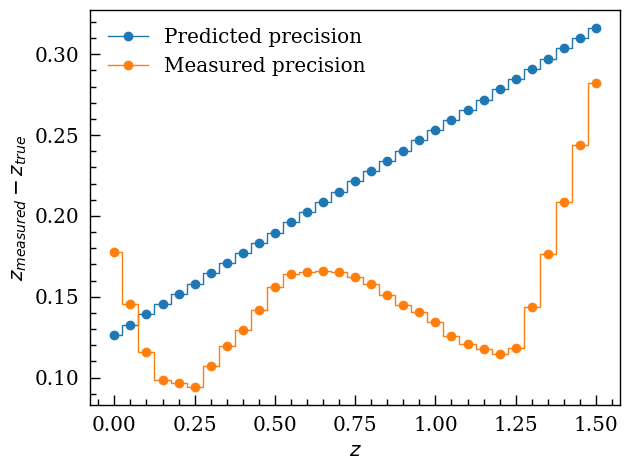

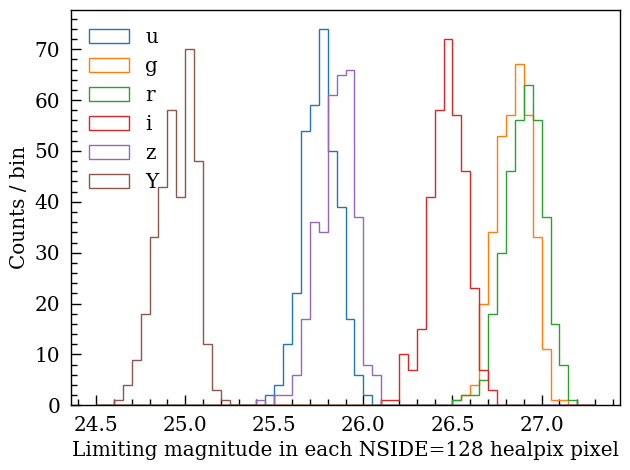

In [164]:
# Now, you have the data
# Make plots

# $P(z)$ distribution
fig, ax = ut.p_z_distribution(data, z_max=2.8, z_step=0.025)

# Luminosity function plot (WIP)
fig, axs, results = ut.luminosityFunction(
    data,
    skysimCat.cosmology,
    p0=[1e-3, -25, -1.15],  # 𝜙∗, 𝑀∗, 𝛼
    z_max=1.4,
    z_step=0.2,
    brightMag=-25,
    faintMag=-15,
    deltaL_mag=0.25,
    maxfev=50000,
)

# Redshift precision relative to expectation
fig, ax = ut.redshiftPrecisionPlot(data, year, modeled=modeled)

# Magnitude non-uniformity plot across healpixel compared to expectation
fig, ax = ut.mag_uniformity_plot(hp_band_dict, hi_mag=27.3, low_mag=24.5)
# Function to check that each healpix pixel satisfies the limiting mag condition
mag_lim_check_result = ut.mag_lim_checker(data, hp_band_dict, NSIDE)

## Fiducial + LSST Y7

## Fiducial + modeled redshift

## Fiducial + $H_0=50 \text{ km s}^{-1} \text{ Mpc}^{-1}$

## Fiducial + 0.3 mag uniformity